## goal

The goal of this notebook is to showcase the python implementation 
using the same dataset as the origninal [scDEED github repository](https://github.com/JSB-UCLA/scDEED/).

I do not aim to make a complete example this, but rather to show the main step of the algorithm as well as the interface to the various function.


The scDEED method relies on the normalization of a metric with a (row-)permuted dataset.

The [original paper](https://www.biorxiv.org/content/10.1101/2023.04.21.537839v1.full) is primarily concerned with single-cell RNAseq data which is known to have a very large number of features (10k or so), many of which are weakly informative, so the authors advise to perform a PCA prior to their method and keep only a small number of PCs (16 in their example).

However, this should not be mandatory for other types of data.


In [1]:
import numba
from umap import UMAP
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist,squareform
import scipy.stats as stats

/home/wandrille/Installed_software/anaconda3/envs/py311/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/wandrille/Installed_software/anaconda3/envs/py311/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/wandrille/Installed_so

### 1. reading the imput data

In order to avoid having to run the singlecell-specific normalization procedure, I grabbed both the original data and the permuted data from their code:

In [2]:
df = pd.read_csv('scDeed_10kHydra_PCA16.csv', index_col=0)
df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16
02-P1_GTCAGCGCTGTG,26.507979,0.504017,3.221825,-2.650461,1.329803,-2.551476,5.520558,1.753692,-17.520220,-9.909145,6.836116,0.549765,-0.280736,-1.507063,5.000204,-1.206309
02-CO_GAAAATAAAGCC,17.788373,-0.558391,1.639503,-0.716677,2.290627,-1.329552,5.541286,2.580751,-10.542725,-10.049659,6.260501,0.264086,-0.890620,0.304573,3.758760,-0.870588
12-N2_ATGAGGGATAGA,-1.929995,-0.838820,-3.849889,6.796622,4.528000,7.061900,3.785956,6.111380,-0.208097,11.806009,2.152902,-1.298445,2.731743,-10.091724,14.986395,7.504356
12-N1_GCCTGAAAAACA,-0.928870,-1.699759,-2.641450,3.678732,3.501603,1.369518,1.773144,1.150686,-0.509970,-0.991760,-0.848202,0.896410,-0.622292,2.705606,-0.555009,0.547838
03-FM_CCGCGTACTTGA,0.367456,-1.153404,-2.043886,3.445670,3.093059,0.200535,3.277318,1.985035,-0.092634,-2.952411,-0.792428,-0.158072,-0.906143,3.070302,-1.590692,0.805208


In [3]:
## permutated data
df_permuted = pd.read_csv('scDeed_10kHydra_permuted_PCA16.csv', index_col=0)
df_permuted.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16
02-P1_GTCAGCGCTGTG,1.697744,0.600726,2.068819,1.007229,-1.025782,0.900258,1.750108,1.044383,-0.988435,0.460240,-0.805825,-0.487723,0.938970,-1.130391,1.807502,0.679643
02-CO_GAAAATAAAGCC,0.302563,0.830654,-0.547273,-0.956924,-1.006113,-0.497147,-2.385261,-0.966937,1.078064,-1.353238,0.345804,-1.216507,3.320852,0.244197,-2.281335,0.570783
12-N2_ATGAGGGATAGA,-0.131945,-1.225169,-0.340892,-1.503378,0.164116,1.097436,2.075292,-0.035023,0.287632,-1.705397,1.783265,-2.442561,-3.727165,-1.775899,1.546757,0.322140
12-N1_GCCTGAAAAACA,1.371550,0.450553,0.417370,0.383840,0.265521,1.223773,-0.422561,0.267847,2.039249,-2.687162,2.587836,1.372216,-1.468616,-0.549136,-0.797895,-1.179718
03-FM_CCGCGTACTTGA,1.797944,-1.116981,-1.786232,1.448153,0.352061,-0.564977,0.286910,-0.005888,-1.202599,-0.348525,-0.997489,-2.247861,-2.179345,3.146422,1.401053,1.274055


## 2. step by step version

So, scDEED cares about classifying the embedding of each point as being "dubious", "good", or "other".

To do so, it computes a "reliability" metric, which corresponds to, for each point, the Pearson correlation of 2 distance vectors:

 * euclidean distance in the low-dimensional space to the x% closest neighbors in low-dimensional space
 * euclidean distance in the low-dimensional space to the x% closest neighbors in high-dimensional space

> NB : this "x%" is called `fraction_selected` in my code.

Then this reliability metric is normalized by comparing it to the reliability metrics of the permuted dataset.


Points with a **reliability lower than the 5th percentile of the permuted dataset reliabilities are called dubious**, 
whereas points with a **reliability higher than the 95th percentile of the permuted dataset reliabilities are called good**

Here I extend this a bit by just using a normalized score which corresponds to the quantile of each reliability in the permuted dataset (so it goes from 0 = bad , to 1 = good).

---

After this, either knowing which points are good or dubious helps users understand which part of their DR they should not trust,

**OR**

the number of dubious point is used as a metric to compare different DR methods (or hyper-parameter sets).


When this in mind, the computations that would be common between different DR methods should be performed separately in order to save computational time.

---

Common steps:
 1. compute permuted dataset (read from file in this example, but see function `permute_data` in `scDEED.py`)
 2. compute ordered neighbors for both the original and permuted dataset

Steps specific to a single DR method:
 1. embed the original and the permuted data
 2. compute reliability on the original and the permuted data
 3. normalize the reliabilities of the original data with the reliabilities of the permuted data
  



**common**

In [14]:
%%time
from scDEED import get_neighbors_matrix , get_reliability_score , get_norm_score , norm_score_to_scDEED

## order neighbors in the original high dim space
high_neighbors_indexes = get_neighbors_matrix(df)

## order neighbors in the permuted high dim space
high_neighbors_permuted_indexes = get_neighbors_matrix(df_permuted)

CPU times: user 4.68 s, sys: 1.21 s, total: 5.9 s
Wall time: 5.9 s


**specific**

In [15]:
%%time
## define embedding function
embedding_function = UMAP( n_neighbors = 5 , min_dist= 0.5 , random_state = 100 ).fit_transform


## embed orginal data
embed = embedding_function( df )

## embed permuted data
embed_perm = embedding_function( df_permuted )


fraction_selected = 0.5 ## default value in the scDEED paper

## compute reliability score for the original and permuted data
r_embed = get_reliability_score(embed , high_neighbors_indexes, fraction_selected)
r_embed_permuted = get_reliability_score(embed_perm , high_neighbors_permuted_indexes, fraction_selected)

## normalize the score withthe permuted data reliability
norm_score = get_norm_score( r_embed, r_embed_permuted )

## in the original paper, normalized scores < 0.05 are "dubious" and normalized score are >0.95 are "good"
scDEED_score = norm_score_to_scDEED(norm_score)

CPU times: user 23.2 s, sys: 322 ms, total: 23.5 s
Wall time: 21.1 s


plotting the results:

<Axes: >

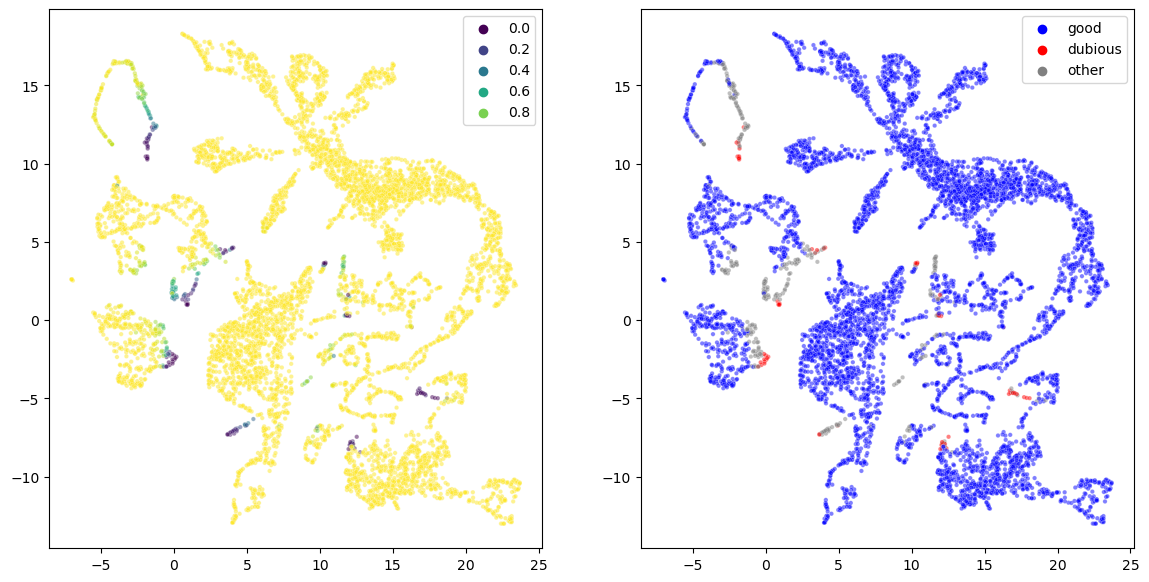

In [16]:
import seaborn as sns

fig,ax = plt.subplots( 1,2 , figsize = (14,7) )

sns.scatterplot( x = embed[:, 0 ] , y = embed[:, 1 ] ,
                s=10, alpha = 0.5,
                hue = norm_score , palette ='viridis',
                ax= ax[0])
sns.scatterplot( x = embed[:, 0 ] , y = embed[:, 1 ] ,
                s=10, alpha = 0.5,
                hue = scDEED_score , palette= {'good':'blue','other':'grey','dubious':'red'},
                ax= ax[1])

## 3. single function call version

small interface to be able to apply this with a single function call:

In [ ]:
## define embedding function
embedding_function = UMAP( n_neighbors = 5 , min_dist= 0.5 , random_state = 100).fit_transform

In [17]:
%%time
from scDEED import scDEED
result_dict = scDEED(df, embedding_function , df_permuted)

embed = result_dict['embedded_data']
norm_score = result_dict['normalized_score']
scDEED_score = result_dict['scDEED_score']

CPU times: user 28 s, sys: 1.32 s, total: 29.3 s
Wall time: 26.9 s


plotting the results:

<Axes: >

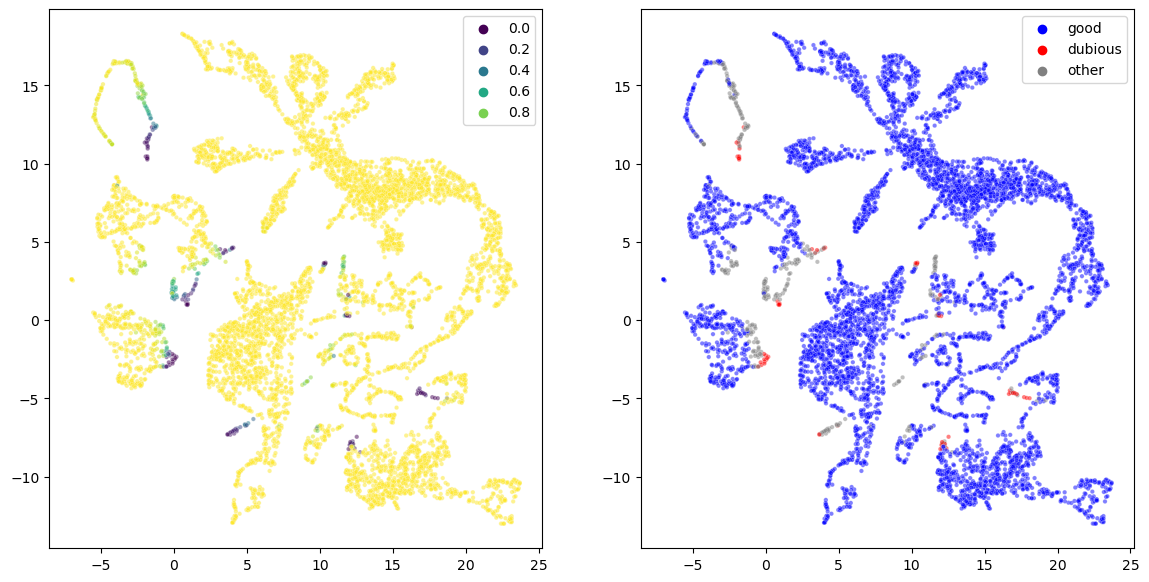

In [18]:
fig,ax = plt.subplots( 1,2 , figsize = (14,7) )

sns.scatterplot( x = embed[:, 0 ] , y = embed[:, 1 ] ,
                s=10, alpha = 0.5,
                hue = norm_score , palette ='viridis',
                ax= ax[0])
sns.scatterplot( x = embed[:, 0 ] , y = embed[:, 1 ] ,
                s=10, alpha = 0.5,
                hue = scDEED_score , palette= {'good':'blue','other':'grey','dubious':'red'},
                ax= ax[1])

Note that the scDEED function only requires the original data and embedding function to run,
in which case it will generate the permuted dataset, and compute all the neighbords ordering itself.

However, any of these can be given to the function to save computational time (useful when you test many parameter combinations):
 * `data_permuted` : the permuted data
 * `high_neighbors_indexes` : matrix of ordered neighbors in the original data
 * `high_neighbors_permuted_indexes` : matrix of ordered neighbors in the permuted data
